# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [108]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

?LogisticRegression

0.6681614349775785


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [110]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [111]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.5739910313901345


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [112]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [113]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [114]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [105]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [117]:
titanic.shape [0]

891

In [118]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.reshape(1,-1)).T

# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

from sklearn.model_selection import train_test_split



# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

## Part 2: Confusion Matrix

0.672645739910314


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [119]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [120]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

Confusion matrix, without normalization
[[107  21]
 [ 52  43]]


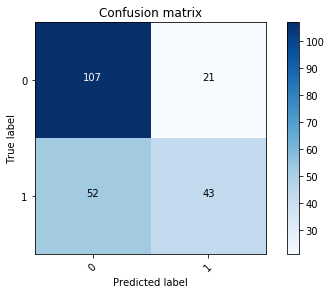

In [121]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [48]:
# calculate the sensitivity ( recall)>> quantas vzs vc acertou o positivo
43 / float(52 + 43)

0.45263157894736844

In [34]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [ ]:
#calculate precision .. qantas vzs o positivo estava correto
43/(43)

In [46]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
# print (y_pred_prob)


Text(0,0.5,'Frequency')

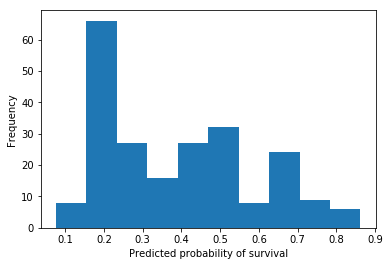

In [47]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [95]:
#probability of survive
rate = titanic.Survived.sum()/titanic.shape[0]
print (rate)

0.3838383838383838


In [96]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > rate , 1, 0)


In [97]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), rate).T

In [98]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[81 47]
 [35 60]]


Confusion matrix, without normalization
[[81 47]
 [35 60]]


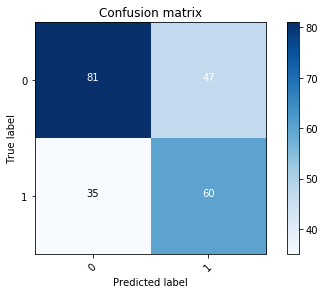

In [99]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [78]:
# new sensitivity/ quantos positivpos de todos positives
print (68 / float(27 + 68))

0.7157894736842105


In [73]:
# new specificity
print (57 / float(57 + 71))

0.4453125


## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [84]:
from sklearn import cross_validation
bikeshare = pd.read_csv('bikeshare.csv')
bikeshare.head()
# bikeshare.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Create dummy variables and set outcome (dependent) variable

In [86]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

#### Create a cross validation with 5 folds

In [89]:
from sklearn import linear_model
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [90]:
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1679.7736709886467
R2: 0.31192125853234776
Model 2
MSE: 1602.7046039207933
R2: 0.3118643629125267
Model 3
MSE: 1616.2039666966464
R2: 0.3118932686580387
Model 4
MSE: 1780.9805170550458
R2: 0.3118831844748289
Model 5
MSE: 1687.2089459407673
R2: 0.3119295477701757
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.3743409203798
Mean of R2 for all folds: 0.31189832446958354


In [91]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 1672.5811076539346
R2:  0.31193460598906453


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

## Part 4: Apply Cross Validation to the Titanic Dataset

In [ ]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [ ]:
titanic.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [ ]:
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) #thats the degree of the X?
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

In [ ]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=100)
print (scores)
print (scores.mean())

### Task: Evaluate each stage of the model with Cross-Validation

In [123]:
kf = cross_validation.KFold(len(X), n_folds=10, shuffle=True)
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    logreg=LogisticRegression(C=1e9).fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], logreg.predict(X.iloc[test_index])))
    scores.append(logreg.score(X, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.28888888888888886
R2: 0.7037037037037037
Model 2
MSE: 0.21348314606741572
R2: 0.7059483726150393
Model 3
MSE: 0.3707865168539326
R2: 0.7014590347923682
Model 4
MSE: 0.2696629213483146
R2: 0.7081930415263749
Model 5
MSE: 0.33707865168539325
R2: 0.7014590347923682
Model 6
MSE: 0.3146067415730337
R2: 0.7059483726150393
Model 7
MSE: 0.29213483146067415
R2: 0.7104377104377104
Model 8
MSE: 0.2808988764044944
R2: 0.7081930415263749
Model 9
MSE: 0.25842696629213485
R2: 0.7025813692480359
Model 10
MSE: 0.29213483146067415
R2: 0.7059483726150393
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.2918102372034956
Mean of R2 for all folds: 0.7053872053872053


### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

In [124]:
kf = cross_validation.KFold(len(X), n_folds=2, shuffle=True)
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    logreg=LogisticRegression(C=1e9).fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], logreg.predict(X.iloc[test_index])))
    scores.append(logreg.score(X, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.3071748878923767
R2: 0.7037037037037037
Model 2
MSE: 0.2943820224719101
R2: 0.6992143658810326
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.3007784551821434
Mean of R2 for all folds: 0.7014590347923682


In [126]:
kf = cross_validation.KFold(len(X), n_folds=50, shuffle=True)
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    logreg=LogisticRegression(C=1e9).fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], logreg.predict(X.iloc[test_index])))
    scores.append(logreg.score(X, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.4444444444444444
R2: 0.7048260381593715
Model 2
MSE: 0.3888888888888889
R2: 0.6992143658810326
Model 3
MSE: 0.4444444444444444
R2: 0.7048260381593715
Model 4
MSE: 0.2222222222222222
R2: 0.7093153759820426
Model 5
MSE: 0.2777777777777778
R2: 0.7048260381593715
Model 6
MSE: 0.2222222222222222
R2: 0.7059483726150393
Model 7
MSE: 0.2777777777777778
R2: 0.7081930415263749
Model 8
MSE: 0.3888888888888889
R2: 0.7070707070707071
Model 9
MSE: 0.2222222222222222
R2: 0.7070707070707071
Model 10
MSE: 0.16666666666666666
R2: 0.7059483726150393
Model 11
MSE: 0.2222222222222222
R2: 0.7059483726150393
Model 12
MSE: 0.2222222222222222
R2: 0.7070707070707071
Model 13
MSE: 0.2777777777777778
R2: 0.7059483726150393
Model 14
MSE: 0.05555555555555555
R2: 0.7059483726150393
Model 15
MSE: 0.3333333333333333
R2: 0.7070707070707071
Model 16
MSE: 0.16666666666666666
R2: 0.7070707070707071
Model 17
MSE: 0.4444444444444444
R2: 0.7014590347923682
Model 18
MSE: 0.4

### Task: Experiment with differen model evaluation metrics form sci-kit learn

See a list of model evaluatin metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html

